In [1]:
import os
import tensorflow        as tf
import numpy             as np
import matplotlib.pyplot as plt
import math
import random
import time
import json
from data_process import *
from Model        import *
from ops          import _weight_variable

BATCH_START    = 0
BATCH_SIZE     = 50
TIME_STEP      = 20
LR             = 0.0001
NUM_SPEAKER    = 77
EPOCH_UP       = 50
EPOCH_LOW      = 30
SPEAKERIDX     = 0
INPUT_SIZE     = 513
OUTPUT_SIZE    = 513
Mem_size       = 16
WINDOW         = 1
TOTAL_SIZE     = 0
model_name = 'Master_Slave2'

In [2]:
start = time.time()
model = Model(INPUT_SIZE, OUTPUT_SIZE, BATCH_SIZE, TIME_STEP, LR, sequence_length=[TIME_STEP]*BATCH_SIZE, window=WINDOW)
init  = tf.global_variables_initializer()
sess  = tf.Session()
sess.run(init)
end = time.time()
print(end-start)

18.2127389908


In [3]:
#saver = tf.train.Saver()
#saver.restore(sess, './Models/Master_Slave2'+str(NUM_SPEAKER)+'.ckpt')

# Training

In [3]:
start = time.time()
mix_train, target1, target2, sequence_length = get_data_train(
    '../mann/Train/Mix/', '../mann/Train/Target1/', '../mann/Train/Target2/', NUM_SPEAKER, BATCH_SIZE, TIME_STEP, longest=200)
end = time.time()
#np.save('./Train/mix.npz', mix)
#np.save('./Train/t1.npz', t1)
#np.save('./Train/t2npz', t2)
print'Get data done!', "    time: ", end-start

Get data done!     time:  1262.55739903


In [4]:
Mstr_LOSS = [np.inf] #np.zeros(EPOCH_UP)
Slv1_LOSS = [np.inf] #np.zeros(EPOCH_UP)
LOSS = [np.inf] #np.zeros(EPOCH_UP)
total_loss = 0
total_Slv1_loss = 0
total_Mstr_loss = 0
for ep in range(EPOCH_UP):
    # Training
    sp_list = [i for i in range(NUM_SPEAKER)]
    random.shuffle(sp_list)    
    sp_idx = 0
    BATCH_idx = 0 # to record starting point of batch we want to extract
    TIME_idx  = 0
    start = time.time()
    while True:
        mix, t1, t2, sequence, sp_idx, BATCH_idx, TIME_idx = get_batch_train(
            mix_train, target1, target2, BATCH_idx, TIME_idx, sp_idx, BATCH_SIZE, TIME_STEP, INPUT_SIZE, sp_list, 
            sequence_length, longest=200, window=WINDOW)     
        
        # break
        if sp_idx == NUM_SPEAKER:
            break
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        model.sequence_length = sequence
        # stochastic gradient descent
        _, Slv1_loss, Mstr_loss, loss = sess.run(
            [model.train_op, model.Slv1_loss, model.Mstr_loss, model.loss],
            feed_dict
            )
        if math.isnan(loss):
            break
        #model.init_state_assign()
        
        # cost
        total_loss += loss
        total_Slv1_loss += Slv1_loss
        total_Mstr_loss += Mstr_loss
    end = time.time()  
    train_time = end-start
    
    TOTAL_SIZE = 0
    for key in sequence_length.keys():
        TOTAL_SIZE += sum(sequence_length[key])
        
    LOSS.append(total_loss/(TOTAL_SIZE))
    Slv1_LOSS.append(total_Slv1_loss/(TOTAL_SIZE))
    Mstr_LOSS.append(total_Mstr_loss/(TOTAL_SIZE))
    total_loss = 0
    total_Mstr_loss = 0
    total_Slv1_loss = 0
    
    
    
    print 'Epoch: ', ep, ' Training Loss: ', LOSS[-1], ' Encoder Loss: ', Slv1_LOSS[-1], ' Decoder Loss: ', Mstr_LOSS[-1], ' Training Time: ', math.ceil(train_time)
    
    if Mstr_LOSS[-2]-Mstr_LOSS[-1] < 0 and ep > 15: #or ep_idx >= 3:
        break
                        
print('----------End----------')

Epoch:  0  Training Loss:  0.718173241229  Encoder Loss:  0.668369286166  Decoder Loss:  0.767977197628  Training Time:  1926.0
Epoch:  1  Training Loss:  0.508680267376  Encoder Loss:  0.514038774966  Decoder Loss:  0.503321760745  Training Time:  1926.0
Epoch:  2  Training Loss:  0.444484774359  Encoder Loss:  0.457256689325  Decoder Loss:  0.431712858878  Training Time:  1926.0
Epoch:  3  Training Loss:  0.401199498388  Encoder Loss:  0.417912168387  Decoder Loss:  0.384486828095  Training Time:  1925.0
Epoch:  4  Training Loss:  0.368379492539  Encoder Loss:  0.38654420524  Decoder Loss:  0.350214780101  Training Time:  1925.0
Epoch:  5  Training Loss:  0.346231710363  Encoder Loss:  0.366814972482  Decoder Loss:  0.325648448494  Training Time:  1926.0
Epoch:  6  Training Loss:  0.328894733726  Encoder Loss:  0.351474965071  Decoder Loss:  0.306314502212  Training Time:  1926.0
Epoch:  7  Training Loss:  0.311964064407  Encoder Loss:  0.335546499204  Decoder Loss:  0.288381630192  

In [5]:
saver = tf.train.Saver()
#save_path = saver.save(sess, "./Models/recall"+str(NUM_SPEAKER)+".ckpt")
save_path = saver.save(sess, "./Models/"+model_name+str(NUM_SPEAKER)+".ckpt")

In [6]:
total_para = 0
for var in tf.trainable_variables():
    shape = var.get_shape()
    tmp = 1
    for dim in shape:
        tmp *= dim.value
    total_para += tmp
print('Total parameters: ', total_para)

('Total parameters: ', 36279978)


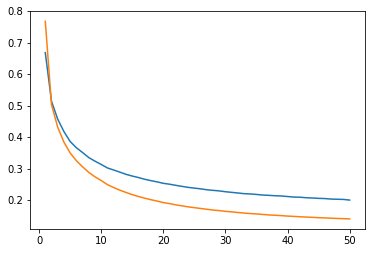

0.718173241229
0.508680267376
0.444484774359
0.401199498388
0.368379492539
0.346231710363
0.328894733726
0.311964064407
0.29925784475
0.2882411332
0.276169978747
0.268303855995
0.26071817505
0.253588174706
0.247428937323
0.242075530508
0.236745381196
0.232119155639
0.228021871833
0.223273319119
0.220269702788
0.216535057
0.213259171143
0.21009205676
0.207607335863
0.205222182725
0.202471030626
0.200289303274
0.19857535262
0.196060161182
0.194291172191
0.19223276106
0.190261873625
0.1890342564
0.187578002988
0.18584333843
0.184622529871
0.183466582343
0.182539541393
0.180924455909
0.179592737815
0.178761020017
0.177472241332
0.176612304022
0.175464310685
0.174790403355
0.173551479088
0.172840852066
0.172246493812
0.170805116849
--------------------
0.668369286166
0.514038774966
0.457256689325
0.417912168387
0.38654420524
0.366814972482
0.351474965071
0.335546499204
0.324084508392
0.313772858575
0.302607654221
0.296109026263
0.289328194404
0.282345753718
0.276864355392
0.272187215654
0.2

In [7]:
%matplotlib inline
fig = plt.figure()
ax  = fig.add_subplot(1, 1, 1)

#ax.plot(LOSS)
ax.plot(Slv1_LOSS)
ax.plot(Mstr_LOSS)
plt.ion()
plt.show()

for idx in LOSS[1:]:
    print idx
print("--------------------")
for idx in Slv1_LOSS[1:]:
    print idx
print("--------------------")
for idx in Mstr_LOSS[1:]:
    print idx

# Test 1: Merge -5 dB

In [5]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test1_merge_-5dB/Mix/', '../mann/Test1_merge_-5dB/Target1/', 
                                                               '../mann/Test1_merge_-5dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((BATCH_SIZE, 539, 539))
total_a2 = np.zeros((BATCH_SIZE, 539, 539))
speaker = mix_test2.keys()
speaker.sort()
for idx in speaker:
    sentence = mix_test2[idx].keys()
    sentence.sort()
    for jdx in sentence:
        model.sequence_length = [sequence_length[idx][jdx]]
        TOTAL_SIZE += sequence_length[idx][jdx][0]
        mix, t1, t2 = mix_test2[idx][jdx], t1_test2[idx][jdx], t2_test2[idx][jdx]
        
        feed_dict = {
            model.x  : mix,
            model.y1 : t1, 
            model.y2 : t2
        }
        loss, pred1, pred2, attention = sess.run(
            [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2, model.attention], 
            feed_dict)
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        total_a1 = np.append(total_a1, attention[0], axis=2)
        total_a2 = np.append(total_a2, attention[1], axis=2)
        # cost
        total_loss += loss
print 'The cost of model: ', total_loss/TOTAL_SIZE
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
total_a1 = total_a1[:, :, 539:]
total_a2 = total_a2[:, :, 539:]

np.savetxt('./Prediction1/Test1_merge_-5dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test1_merge_-5dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred2, delimiter=",")

AttributeError: 'numpy.ndarray' object has no attribute 'keys'

In [18]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test1_merge_-5dB/Mix/', '../mann/Test1_merge_-5dB/Target1/', 
                                                               '../mann/Test1_merge_-5dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((BATCH_SIZE, 20, 20))
total_a2 = np.zeros((BATCH_SIZE, 20, 20))
total_c1 = np.zeros((1, 800))
total_c2 = np.zeros((1, 800))
sp_list     = mix_test2.keys()
sp_list.sort()
for speaker in range(NUM_SPEAKER_TEST):
    BATCH_START = 0 # to record starting point of batch we want to extract
    DATA_SIZE   = mix_test2[sp_list[speaker]].shape[0]
    TOTAL_SIZE  = TOTAL_SIZE + DATA_SIZE
    for idx in range((DATA_SIZE/(BATCH_SIZE*TIME_STEP))):
        BATCH_START = idx*BATCH_SIZE*TIME_STEP
        mix, t1, t2 = get_batch_test(
            mix_test2[sp_list[speaker]], t1_test2[sp_list[speaker]], t2_test2[sp_list[speaker]], 
            BATCH_START, BATCH_SIZE, TIME_STEP, INPUT_SIZE, dim=True)
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        if idx==(DATA_SIZE/(BATCH_SIZE*TIME_STEP))-1:
            model.sequence_length = sequence_length[sp_list[speaker]]
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
            model.sequence_length = [TIME_STEP for i in xrange(0, BATCH_SIZE)]
        else:
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Slv1_pred1, model.Slv1_pred2],
                feed_dict
                )
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        #total_a1 = np.append(total_a1, attention[0], axis=2)
        #total_a2 = np.append(total_a2, attention[1], axis=2)
        #total_c1 = np.append(total_c1, attention[2], axis=0)
        #total_c2 = np.append(total_c2, attention[3], axis=0)
        # cost
        total_loss += loss
            
total_loss = total_loss/(TOTAL_SIZE)
print 'The cost of model: ', total_loss
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
#total_a1 = total_a1[:, :, 20:]
#total_a2 = total_a2[:, :, 20:]
#total_c1 = total_c1[1:, :]
#total_c2 = total_c2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
#total_c1 = np.transpose(total_c1)
#total_c2 = np.transpose(total_c2)
            

np.savetxt('./Prediction1/Test1_merge_-5dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test1_merge_-5dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred2, delimiter=",")
#np.savetxt('./Prediction1/Test1/attention_a1.csv', np.reshape(total_a1, [50, 20*960]), delimiter=",")
#np.savetxt('./Prediction1/Test1/attention_a2.csv', np.reshape(total_a2, [50, 20*960]), delimiter=",")
#np.savetxt('./Prediction1/Test1/attention_c1.csv', total_c1, delimiter=",")
#np.savetxt('./Prediction1/Test1/attention_c2.csv', total_c2, delimiter=",")
print('----------End----------')

The cost of model:  0.213565524975
----------End----------


# Test 2: Merge -5dB

In [25]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test2_merge_-5dB/Mix/', '../mann/Test2_merge_-5dB/Target1/', 
                                                               '../mann/Test2_merge_-5dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((BATCH_SIZE, 539, 539))
total_a2 = np.zeros((BATCH_SIZE, 539, 539))
speaker = mix_test2.keys()
speaker.sort()
for idx in speaker:
    sentence = mix_test2[idx].keys()
    sentence.sort()
    for jdx in sentence:
        model.sequence_length = [sequence_length[idx][jdx]]
        TOTAL_SIZE += sequence_length[idx][jdx][0]
        mix, t1, t2 = mix_test2[idx][jdx], t1_test2[idx][jdx], t2_test2[idx][jdx]
        
        feed_dict = {
            model.x  : mix,
            model.y1 : t1, 
            model.y2 : t2
        }
        loss, pred1, pred2, attention = sess.run(
            [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2, model.attention], 
            feed_dict)
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        total_a1 = np.append(total_a1, attention[0], axis=2)
        total_a2 = np.append(total_a2, attention[1], axis=2)
        # cost
        total_loss += loss
print 'The cost of model: ', total_loss/TOTAL_SIZE
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
total_a1 = total_a1[:, :, 539:]
total_a2 = total_a2[:, :, 539:]

np.savetxt('./Prediction1/Test2_merge_-5dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test2_merge_-5dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred2, delimiter=",")
np.savetxt('./Prediction1/Test2_merge_-5dB/attention_a1_long_sequence.csv', total_a1[0], delimiter=",")
np.savetxt('./Prediction1/Test2_merge_-5dB/attention_a2_long_sequence.csv', total_a2[0], delimiter=",")

The cost of model:  22538.4592972


In [19]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test2_merge_-5dB/Mix/', '../mann/Test2_merge_-5dB/Target1/', 
                                                                      '../mann/Test2_merge_-5dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((BATCH_SIZE, 20, 20))
total_a2 = np.zeros((BATCH_SIZE, 20, 20))
total_c1 = np.zeros((1, 800))
total_c2 = np.zeros((1, 800))
sp_list     = mix_test2.keys()
sp_list.sort()
for speaker in range(NUM_SPEAKER_TEST):
    BATCH_START = 0 # to record starting point of batch we want to extract
    DATA_SIZE   = mix_test2[sp_list[speaker]].shape[0]
    TOTAL_SIZE  = TOTAL_SIZE + DATA_SIZE
    for idx in range((DATA_SIZE/(BATCH_SIZE*TIME_STEP))):
        BATCH_START = idx*BATCH_SIZE*TIME_STEP
        mix, t1, t2 = get_batch_test(
            mix_test2[sp_list[speaker]], t1_test2[sp_list[speaker]], t2_test2[sp_list[speaker]], 
            BATCH_START, BATCH_SIZE, TIME_STEP, INPUT_SIZE, dim=True)
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        if idx==(DATA_SIZE/(BATCH_SIZE*TIME_STEP))-1:
            model.sequence_length = sequence_length[sp_list[speaker]]
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
            model.sequence_length = [TIME_STEP for i in xrange(0, BATCH_SIZE)]
        else:
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        #total_a1 = np.append(total_a1, attention[0], axis=2)
        #total_a2 = np.append(total_a2, attention[1], axis=2)
        #total_c1 = np.append(total_c1, attention[2], axis=0)
        #total_c2 = np.append(total_c2, attention[3], axis=0)
        # cost
        total_loss += loss
            
total_loss = total_loss/(TOTAL_SIZE)
print 'The cost of model: ', total_loss
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
#total_a1 = total_a1[:, :, 20:]
#total_a2 = total_a2[:, :, 20:]
#total_c1 = total_c1[1:, :]
#total_c2 = total_c2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
#total_c1 = np.transpose(total_c1)
#total_c2 = np.transpose(total_c2)
            
np.savetxt('./Prediction1/Test2_merge_-5dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test2_merge_-5dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred2, delimiter=",")
#np.savetxt('./Prediction1/Test2/attention_a1.csv', np.reshape(total_a1, [50, 20*960]), delimiter=",")
#np.savetxt('./Prediction1/Test2/attention_a2.csv', np.reshape(total_a2, [50, 20*960]), delimiter=",")
#np.savetxt('./Prediction1/Test2/attention_c1.csv', total_c1, delimiter=",")
#np.savetxt('./Prediction1/Test2/attention_c2.csv', total_c2, delimiter=",")
print('----------End----------')

The cost of model:  0.388802303173
----------End----------


# Test 1: Merge 0 dB

In [26]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test1_merge_0dB/Mix/', '../mann/Test1_merge_0dB/Target1/', 
                                                               '../mann/Test1_merge_0dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((BATCH_SIZE, 539, 539))
total_a2 = np.zeros((BATCH_SIZE, 539, 539))
speaker = mix_test2.keys()
speaker.sort()
for idx in speaker:
    sentence = mix_test2[idx].keys()
    sentence.sort()
    for jdx in sentence:
        model.sequence_length = [sequence_length[idx][jdx]]
        TOTAL_SIZE += sequence_length[idx][jdx][0]
        mix, t1, t2 = mix_test2[idx][jdx], t1_test2[idx][jdx], t2_test2[idx][jdx]
        
        feed_dict = {
            model.x  : mix,
            model.y1 : t1, 
            model.y2 : t2
        }
        loss, pred1, pred2, attention = sess.run(
            [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2, model.attention], 
            feed_dict)
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        total_a1 = np.append(total_a1, attention[0], axis=2)
        total_a2 = np.append(total_a2, attention[1], axis=2)
        # cost
        total_loss += loss
print 'The cost of model: ', total_loss/TOTAL_SIZE
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
total_a1 = total_a1[:, :, 539:]
total_a2 = total_a2[:, :, 539:]

np.savetxt('./Prediction1/Test1_merge_0dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test1_merge_0dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred2, delimiter=",")
np.savetxt('./Prediction1/Test1_merge_0dB/attention_a1_long_sequence.csv', total_a1[0], delimiter=",")
np.savetxt('./Prediction1/Test1_merge_0dB/attention_a2_long_sequence.csv', total_a2[0], delimiter=",")

The cost of model:  13783.1533566


In [25]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test1_merge_0dB/Mix/', '../mann/Test1_merge_0dB/Target1/', 
                                                               '../mann/Test1_merge_0dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
sp_list     = mix_test2.keys()
sp_list.sort()
for speaker in range(NUM_SPEAKER_TEST):
    BATCH_START = 0 # to record starting point of batch we want to extract
    DATA_SIZE   = mix_test2[sp_list[speaker]].shape[0]
    TOTAL_SIZE  = TOTAL_SIZE + DATA_SIZE
    for idx in range((DATA_SIZE/(BATCH_SIZE*TIME_STEP))):
        BATCH_START = idx*BATCH_SIZE*TIME_STEP
        mix, t1, t2 = get_batch_test(
            mix_test2[sp_list[speaker]], t1_test2[sp_list[speaker]], t2_test2[sp_list[speaker]], 
            BATCH_START, BATCH_SIZE, TIME_STEP, INPUT_SIZE, dim=True)
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        if idx==(DATA_SIZE/(BATCH_SIZE*TIME_STEP))-1:
            model.sequence_length = sequence_length[sp_list[speaker]]
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
            model.sequence_length = [TIME_STEP for i in xrange(0, BATCH_SIZE)]
        else:
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        # cost
        total_loss += loss
            
total_loss = total_loss/(TOTAL_SIZE)
print 'The cost of model: ', total_loss
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
            
print('----------End----------')

np.savetxt('./Prediction1/Test1_merge_0dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test1_merge_0dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred2, delimiter=",")

The cost of model:  0.10618849497
----------End----------


# Test 2: Merge 0 dB

In [27]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test2_merge_0dB/Mix/', '../mann/Test2_merge_0dB/Target1/', 
                                                               '../mann/Test2_merge_0dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((BATCH_SIZE, 539, 539))
total_a2 = np.zeros((BATCH_SIZE, 539, 539))
speaker = mix_test2.keys()
speaker.sort()
for idx in speaker:
    sentence = mix_test2[idx].keys()
    sentence.sort()
    for jdx in sentence:
        model.sequence_length = [sequence_length[idx][jdx]]
        TOTAL_SIZE += sequence_length[idx][jdx][0]
        mix, t1, t2 = mix_test2[idx][jdx], t1_test2[idx][jdx], t2_test2[idx][jdx]
        
        feed_dict = {
            model.x  : mix,
            model.y1 : t1, 
            model.y2 : t2
        }
        loss, pred1, pred2, attention = sess.run(
            [model.Dec_loss, model.Dec_pred1, model.Dec_pred2, model.attention], 
            feed_dict)
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        total_a1 = np.append(total_a1, attention[0], axis=2)
        total_a2 = np.append(total_a2, attention[1], axis=2)
        # cost
        total_loss += loss
print 'The cost of model: ', total_loss/TOTAL_SIZE
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
total_a1 = total_a1[:, :, 539:]
total_a2 = total_a2[:, :, 539:]

np.savetxt('./Prediction1/Test2_merge_0dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test2_merge_0dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred2, delimiter=",")
np.savetxt('./Prediction1/Test2_merge_0dB/attention_a1_long_sequence.csv', total_a1[0], delimiter=",")
np.savetxt('./Prediction1/Test2_merge_0dB/attention_a2_long_sequence.csv', total_a2[0], delimiter=",")

The cost of model:  18847.9772606


In [26]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test2_merge_0dB/Mix/', '../mann/Test2_merge_0dB/Target1/', 
                                                               '../mann/Test2_merge_0dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
total_enc_loss = 0
total_dec_loss = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
sp_list     = mix_test2.keys()
sp_list.sort()
for speaker in range(NUM_SPEAKER_TEST):
    BATCH_START = 0 # to record starting point of batch we want to extract
    DATA_SIZE   = mix_test2[sp_list[speaker]].shape[0]
    TOTAL_SIZE  = TOTAL_SIZE + DATA_SIZE
    for idx in range((DATA_SIZE/(BATCH_SIZE*TIME_STEP))):
        BATCH_START = idx*BATCH_SIZE*TIME_STEP
        mix, t1, t2 = get_batch_test(
            mix_test2[sp_list[speaker]], t1_test2[sp_list[speaker]], t2_test2[sp_list[speaker]], 
            BATCH_START, BATCH_SIZE, TIME_STEP, INPUT_SIZE, dim=True)
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        if idx==(DATA_SIZE/(BATCH_SIZE*TIME_STEP))-1:
            model.sequence_length = sequence_length[sp_list[speaker]]
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
            model.sequence_length = [TIME_STEP for i in xrange(0, BATCH_SIZE)]
        else:
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        # cost
        total_loss += loss
            
total_loss = total_loss/(TOTAL_SIZE)
print 'The cost of model: ', total_loss
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
            
print('----------End----------')

np.savetxt('./Prediction1/Test2_merge_0dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test2_merge_0dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred2, delimiter=",")

The cost of model:  0.180737709893
----------End----------


# Test 1: Merge 5 dB

In [28]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test1_merge_5dB/Mix/', '../mann/Test1_merge_5dB/Target1/', 
                                                               '../mann/Test1_merge_5dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((BATCH_SIZE, 539, 539))
total_a2 = np.zeros((BATCH_SIZE, 539, 539))
speaker = mix_test2.keys()
speaker.sort()
for idx in speaker:
    sentence = mix_test2[idx].keys()
    sentence.sort()
    for jdx in sentence:
        model.sequence_length = [sequence_length[idx][jdx]]
        TOTAL_SIZE += sequence_length[idx][jdx][0]
        mix, t1, t2 = mix_test2[idx][jdx], t1_test2[idx][jdx], t2_test2[idx][jdx]
        
        feed_dict = {
            model.x  : mix,
            model.y1 : t1, 
            model.y2 : t2
        }
        loss, pred1, pred2, attention = sess.run(
            [model.Dec_loss, model.Dec_pred1, model.Dec_pred2, model.attention], 
            feed_dict)
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        total_a1 = np.append(total_a1, attention[0], axis=2)
        total_a2 = np.append(total_a2, attention[1], axis=2)
        # cost
        total_loss += loss
print 'The cost of model: ', total_loss/TOTAL_SIZE
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
total_a1 = total_a1[:, :, 539:]
total_a2 = total_a2[:, :, 539:]

np.savetxt('./Prediction1/Test1_merge_5dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test1_merge_5dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred2, delimiter=",")
np.savetxt('./Prediction1/Test1_merge_5dB/attention_a1_long_sequence.csv', total_a1[0], delimiter=",")
np.savetxt('./Prediction1/Test1_merge_5dB/attention_a2_long_sequence.csv', total_a2[0], delimiter=",")

The cost of model:  11156.1681662


In [27]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test1_merge_5dB/Mix/', '../mann/Test1_merge_5dB/Target1/', 
                                                               '../mann/Test1_merge_5dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
sp_list     = mix_test2.keys()
sp_list.sort()
for speaker in range(NUM_SPEAKER_TEST):
    BATCH_START = 0 # to record starting point of batch we want to extract
    DATA_SIZE   = mix_test2[sp_list[speaker]].shape[0]
    TOTAL_SIZE  = TOTAL_SIZE + DATA_SIZE
    for idx in range((DATA_SIZE/(BATCH_SIZE*TIME_STEP))):
        BATCH_START = idx*BATCH_SIZE*TIME_STEP
        mix, t1, t2 = get_batch_test(
            mix_test2[sp_list[speaker]], t1_test2[sp_list[speaker]], t2_test2[sp_list[speaker]], 
            BATCH_START, BATCH_SIZE, TIME_STEP, INPUT_SIZE, dim=True)
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        if idx==(DATA_SIZE/(BATCH_SIZE*TIME_STEP))-1:
            model.sequence_length = sequence_length[sp_list[speaker]]
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
            model.sequence_length = [TIME_STEP for i in xrange(0, BATCH_SIZE)]
        else:
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        # cost
        total_loss += loss
            
total_loss = total_loss/(TOTAL_SIZE)
print 'The cost of model: ', total_loss
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
            
print('----------End----------')

np.savetxt('./Prediction1/Test1_merge_5dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test1_merge_5dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred2, delimiter=",")

The cost of model:  0.0619891352256
----------End----------


# Test 2: Merge 5 dB

In [29]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test2_merge_5dB/Mix/', '../mann/Test2_merge_5dB/Target1/', 
                                                               '../mann/Test2_merge_5dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((BATCH_SIZE, 539, 539))
total_a2 = np.zeros((BATCH_SIZE, 539, 539))
speaker = mix_test2.keys()
speaker.sort()
for idx in speaker:
    sentence = mix_test2[idx].keys()
    sentence.sort()
    for jdx in sentence:
        model.sequence_length = [sequence_length[idx][jdx]]
        TOTAL_SIZE += sequence_length[idx][jdx][0]
        mix, t1, t2 = mix_test2[idx][jdx], t1_test2[idx][jdx], t2_test2[idx][jdx]
        
        feed_dict = {
            model.x  : mix,
            model.y1 : t1, 
            model.y2 : t2
        }
        loss, pred1, pred2, attention = sess.run(
            [model.Dec_loss, model.Dec_pred1, model.Dec_pred2, model.attention], 
            feed_dict)
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        total_a1 = np.append(total_a1, attention[0], axis=2)
        total_a2 = np.append(total_a2, attention[1], axis=2)
        # cost
        total_loss += loss
print 'The cost of model: ', total_loss/TOTAL_SIZE
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
total_a1 = total_a1[:, :, 539:]
total_a2 = total_a2[:, :, 539:]

np.savetxt('./Prediction1/Test2_merge_5dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test2_merge_5dB/'+model_name+'_'+str(NUM_SPEAKER)+'_long_sequence.csv', total_pred2, delimiter=",")
np.savetxt('./Prediction1/Test2_merge_5dB/attention_a1_long_sequence.csv', total_a1[0], delimiter=",")
np.savetxt('./Prediction1/Test2_merge_5dB/attention_a2_long_sequence.csv', total_a2[0], delimiter=",")

The cost of model:  16550.0468979


In [30]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, sequence_length = get_data_test('../mann/Test2_merge_5dB/Mix/', '../mann/Test2_merge_5dB/Target1/', 
                                                               '../mann/Test2_merge_5dB/Target2/', NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)

total_loss  = 0
total_enc_loss = 0
total_dec_loss = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
sp_list     = mix_test2.keys()
sp_list.sort()
for speaker in range(NUM_SPEAKER_TEST):
    BATCH_START = 0 # to record starting point of batch we want to extract
    DATA_SIZE   = mix_test2[sp_list[speaker]].shape[0]
    TOTAL_SIZE  = TOTAL_SIZE + DATA_SIZE
    for idx in range((DATA_SIZE/(BATCH_SIZE*TIME_STEP))):
        BATCH_START = idx*BATCH_SIZE*TIME_STEP
        mix, t1, t2 = get_batch_test(
            mix_test2[sp_list[speaker]], t1_test2[sp_list[speaker]], t2_test2[sp_list[speaker]], 
            BATCH_START, BATCH_SIZE, TIME_STEP, INPUT_SIZE, dim=True)
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        if idx==(DATA_SIZE/(BATCH_SIZE*TIME_STEP))-1:
            model.sequence_length = sequence_length[sp_list[speaker]]
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
            model.sequence_length = [TIME_STEP for i in xrange(0, BATCH_SIZE)]
        else:
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        # cost
        total_loss += loss
            
total_loss = total_loss/(TOTAL_SIZE)
print 'The cost of model: ', total_loss
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
            
print('----------End----------')

np.savetxt('./Prediction1/Test2_merge_5dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test2_merge_5dB/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred2, delimiter=",")

The cost of model:  0.09385864498
----------End----------


# Test1

In [7]:
NUM_SPEAKER_TEST = 6
mix_test1, t1_test1, t2_test1, order, sequence_length = get_data_test('../mann/Test1/Mix/', '../mann/Test1/Target1/', '../mann/Test1/Target2/', 
                                                                      NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)
total_loss  = 0
total_enc_loss = 0
total_dec_loss = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((1, 800))
total_a2 = np.zeros((1, 800))
total_c1 = np.zeros((1, 800))
total_c2 = np.zeros((1, 800))
sp_list     = mix_test1.keys()
sp_list.sort()
for speaker in range(NUM_SPEAKER_TEST):
    BATCH_START = 0 # to record starting point of batch we want to extract
    DATA_SIZE   = mix_test1[sp_list[speaker]].shape[0]
    TOTAL_SIZE  = TOTAL_SIZE + DATA_SIZE
    for idx in range((DATA_SIZE/(BATCH_SIZE*TIME_STEP))):
        BATCH_START = idx*BATCH_SIZE*TIME_STEP
        mix, t1, t2 = get_batch_test(
            mix_test1[sp_list[speaker]], t1_test1[sp_list[speaker]], t2_test1[sp_list[speaker]], 
            BATCH_START, BATCH_SIZE, TIME_STEP, INPUT_SIZE, dim=True)
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        if idx==(DATA_SIZE/(BATCH_SIZE*TIME_STEP))-1:
            model.sequence_length = sequence_length[sp_list[speaker]]
            # stochastic gradient descent
            loss, pred1, pred2, attention = sess.run(
                [model.Dec_loss, model.Dec_pred1, model.Dec_pred2, model.attention],
                feed_dict
                )
            model.sequence_length = [TIME_STEP for i in xrange(0, BATCH_SIZE)]
        else:
            # stochastic gradient descent
            loss, enc_loss, dec_loss, pred1, pred2, attention = sess.run(
                [model.Dec_loss, model.Enc_loss, model.Dec_loss, model.Dec_pred1, model.Dec_pred2, model.attention],
                feed_dict
                )
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        total_a1 = np.append(total_a1, attention[0], axis=0)
        total_a2 = np.append(total_a2, attention[1], axis=0)
        total_c1 = np.append(total_c1, attention[2], axis=0)
        total_c2 = np.append(total_c2, attention[3], axis=0)
        # cost
        total_loss += loss
        total_enc_loss += enc_loss
        total_dec_loss += dec_loss
            
total_loss = total_loss/(TOTAL_SIZE)
print 'The cost of model: ', total_loss
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_a1 = total_a1[1:, :]
total_a2 = total_a2[1:, :]
total_c1 = total_c1[1:, :]
total_c2 = total_c2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
total_a1 = np.transpose(total_a1)
total_a2 = np.transpose(total_a2)
total_c1 = np.transpose(total_c1)
total_c2 = np.transpose(total_c2)
            
np.savetxt('./Prediction1/Test1/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test1/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred2, delimiter=",")
np.savetxt('./Prediction1/Test1/attention_a1.csv', total_a1, delimiter=",")
np.savetxt('./Prediction1/Test1/attention_a2.csv', total_a2, delimiter=",")
np.savetxt('./Prediction1/Test1/attention_c1.csv', total_c1, delimiter=",")
np.savetxt('./Prediction1/Test1/attention_c2.csv', total_c2, delimiter=",")

print('----------End----------')

The cost of model:  0.216931670586
----------End----------


# Test2

In [8]:
NUM_SPEAKER_TEST = 6
mix_test2, t1_test2, t2_test2, order, sequence_length = get_data_test('../mann/Test2/Mix/', '../mann/Test2/Target1/', '../mann/Test2/Target2/', 
                                                                      NUM_SPEAKER_TEST, BATCH_SIZE, TIME_STEP)
total_loss  = 0
total_enc_loss = 0
total_dec_loss = 0
TOTAL_SIZE  = 0
total_pred1 = np.zeros((1, 513))
total_pred2 = np.zeros((1, 513))
total_a1 = np.zeros((1, 800))
total_a2 = np.zeros((1, 800))
total_c1 = np.zeros((1, 800))
total_c2 = np.zeros((1, 800))
sp_list     = mix_test2.keys()
sp_list.sort()
for speaker in range(NUM_SPEAKER_TEST):
    BATCH_START = 0 # to record starting point of batch we want to extract
    DATA_SIZE   = mix_test2[sp_list[speaker]].shape[0]
    TOTAL_SIZE  = TOTAL_SIZE + DATA_SIZE
    for idx in range((DATA_SIZE/(BATCH_SIZE*TIME_STEP))):
        BATCH_START = idx*BATCH_SIZE*TIME_STEP
        mix, t1, t2 = get_batch_test(
            mix_test2[sp_list[speaker]], t1_test2[sp_list[speaker]], t2_test2[sp_list[speaker]], 
            BATCH_START, BATCH_SIZE, TIME_STEP, INPUT_SIZE, dim=True)
        
        feed_dict = {
                model.x  : mix,
                model.y1 : t1,
                model.y2 : t2
            }
        
        if idx==(DATA_SIZE/(BATCH_SIZE*TIME_STEP))-1:
            model.sequence_length = sequence_length[sp_list[speaker]]
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
            model.sequence_length = [TIME_STEP for i in xrange(0, BATCH_SIZE)]
        else:
            # stochastic gradient descent
            loss, pred1, pred2 = sess.run(
                [model.Mstr_loss, model.Mstr_pred1, model.Mstr_pred2],
                feed_dict
                )
        
        total_pred1 = np.append(total_pred1, pred1, axis=0)
        total_pred2 = np.append(total_pred2, pred2, axis=0)
        total_a1 = np.append(total_a1, attention[0], axis=0)
        total_a2 = np.append(total_a2, attention[1], axis=0)
        total_c1 = np.append(total_c1, attention[2], axis=0)
        total_c2 = np.append(total_c2, attention[3], axis=0)
        # cost
        total_loss += loss
            
total_loss = total_loss/(TOTAL_SIZE)
print 'The cost of model: ', total_loss
total_pred1 = total_pred1[1:, :]
total_pred2 = total_pred2[1:, :]
total_a1 = total_a1[1:, :]
total_a2 = total_a2[1:, :]
total_c1 = total_c1[1:, :]
total_c2 = total_c2[1:, :]
total_pred1 = np.transpose(total_pred1)
total_pred2 = np.transpose(total_pred2)
total_a1 = np.transpose(total_a1)
total_a2 = np.transpose(total_a2)
total_c1 = np.transpose(total_c1)
total_c2 = np.transpose(total_c2)
            
np.savetxt('./Prediction1/Test2/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred1, delimiter=",")
np.savetxt('./Prediction2/Test2/'+model_name+'_'+str(NUM_SPEAKER)+'.csv', total_pred2, delimiter=",")
np.savetxt('./Prediction1/Test2/attention_a1.csv', total_a1, delimiter=",")
np.savetxt('./Prediction1/Test2/attention_a2.csv', total_a2, delimiter=",")
np.savetxt('./Prediction1/Test2/attention_c1.csv', total_c1, delimiter=",")
np.savetxt('./Prediction1/Test2/attention_c2.csv', total_c2, delimiter=",")

print('----------End----------')

The cost of model:  0.352608662782
----------End----------
